In [1]:
import os
os.chdir("..")

from src.data_loader import DatabaseConnection

In [2]:
db_connection = DatabaseConnection(
    ssh_host='www.redesign777.tokyo',
    ssh_port=22,
    ssh_user='rddev',
    ssh_password='rdDev@20240521',
    db_host='localhost',
    db_port=3306,
    db_user='rddev',
    db_password='rdSql@20240521',
    db_name='redesign'
)
db_connection.start_tunnel()

2024-08-31 06:08:30,375| ERROR   | Password is required for key C:\Users\yshim/.ssh\id_rsa


SSHトンネルが 56053 にバインドされました。


In [3]:
# クエリを実行
df_frame = db_connection.execute_query("SELECT * FROM re_m_frame")
df_katashiki = db_connection.execute_query("SELECT * FROM re_m_katashiki")
df_pachinko = db_connection.execute_query("SELECT * FROM re_m_katashikidetailpachinko")
df_slot = db_connection.execute_query("SELECT * FROM re_m_katashikidetailslot")
df_katashiki_frame_relation = db_connection.execute_query("SELECT * FROM re_m_katashikiframerelation")
df_maker = db_connection.execute_query("SELECT * FROM re_m_maker")
df_model_evaluation = db_connection.execute_query("SELECT * FROM re_m_modelevaluation")
df_pachinko_type = db_connection.execute_query("SELECT * FROM re_m_pachinkotype")
df_pachinko_type_detail = db_connection.execute_query("SELECT * FROM re_m_pachinkotypedetail")
# SSHトンネルを閉じる
db_connection.close_tunnel()

SSHトンネルを閉じました。


In [4]:
from src.data_preprocessing import data_preprocessing_operator
import configparser

config = configparser.ConfigParser()
config.read('config.ini')

# start_date :　抽出データ開始日
# end_date : 抽出データ終了日
# openai_api_key : openaiのAPIキー
# use_existing_brand : 既存のブランドデータを使うかどうか
# brand_output_path : 抽出したブランドリストを出力するパス

data_model = data_preprocessing_operator(start_date="2020/01/01 00:00:00",
                                        end_date="2024/08/20 23:59:59",
                                        openai_api_key=config['openai']['api_key'],
                                        use_existing_brand=True,
                                        brand_output_path='brand_lists/brand_list_20200101_20240820.csv')

existing_brand_path = 'brand_lists/brand_list_20200101_20240616.csv'

df = data_model.process( 
                df_frame,
                df_katashiki,
                df_pachinko,
                df_slot,
                df_katashiki_frame_relation,
                df_model_evaluation,
                df_pachinko_type,
                df_pachinko_type_detail, existing_brand_path)

In [6]:
df[['ModelLife', 'GrossProfit']]

,ModelLife,GrossProfit
0,12.0,532293.0
1,6.0,148296.0
2,16.0,456679.0
3,0.0,0.0
4,5.0,194114.0
...,...,...
522,6.0,259259.0
523,4.0,173230.0
524,8.0,269690.0
525,15.0,520392.0


In [7]:
df = df[df['GrossProfit'] > 0]
df = df[df['ModelLife'] > 0]

# 貢献週と粗利益の相関

Text(0, 0.5, 'GrossProfit')

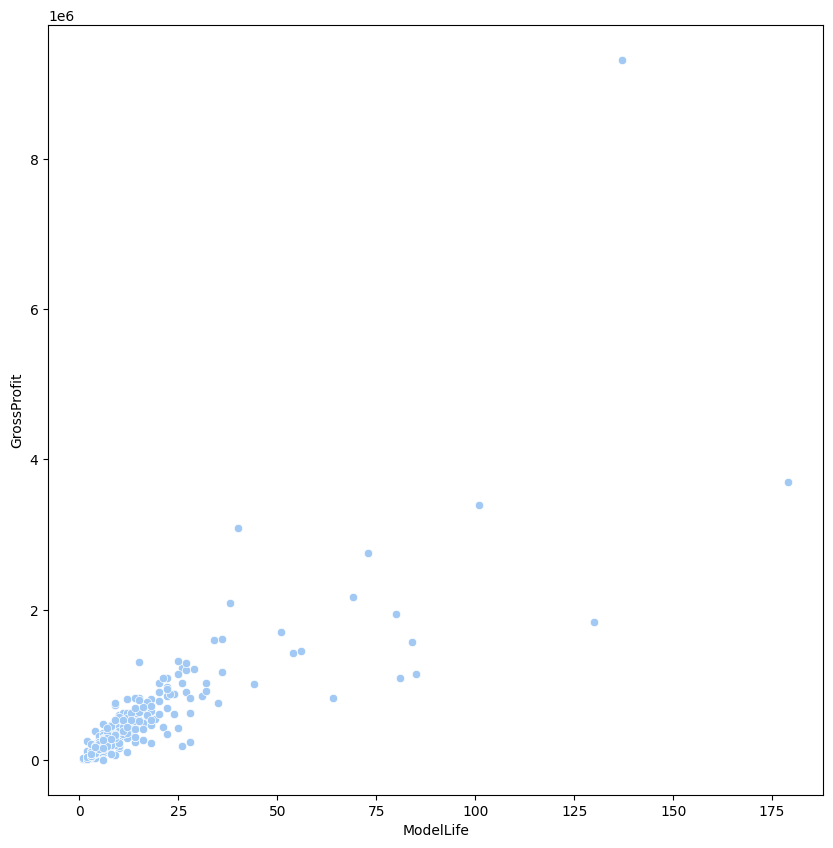

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_palette("pastel")

plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['ModelLife'], y=df['GrossProfit'])

plt.xlabel('ModelLife')
plt.ylabel('GrossProfit')

Text(0, 0.5, 'GrossProfit')

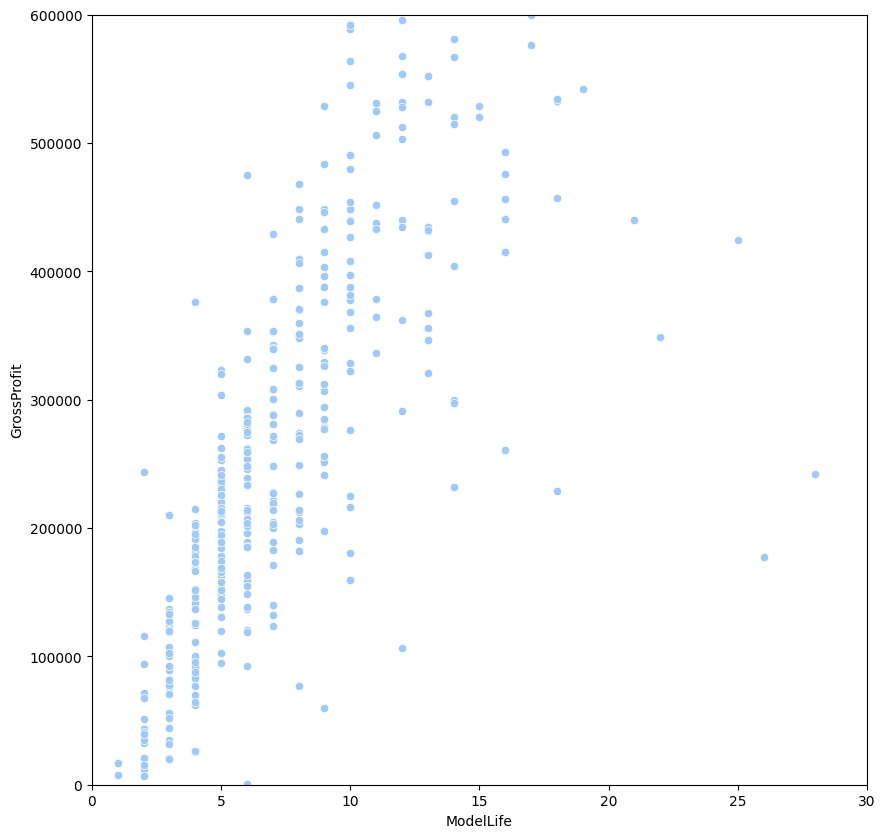

In [15]:
sns.set_palette("pastel")

plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['ModelLife'], y=df['GrossProfit'])

plt.xlim([0, 30])
plt.ylim([0, 600000])

plt.xlabel('ModelLife')
plt.ylabel('GrossProfit')

In [16]:
import pandas as pd

# 学習とテストデータの定義
df_train = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

Text(0, 0.5, 'GrossProfit')

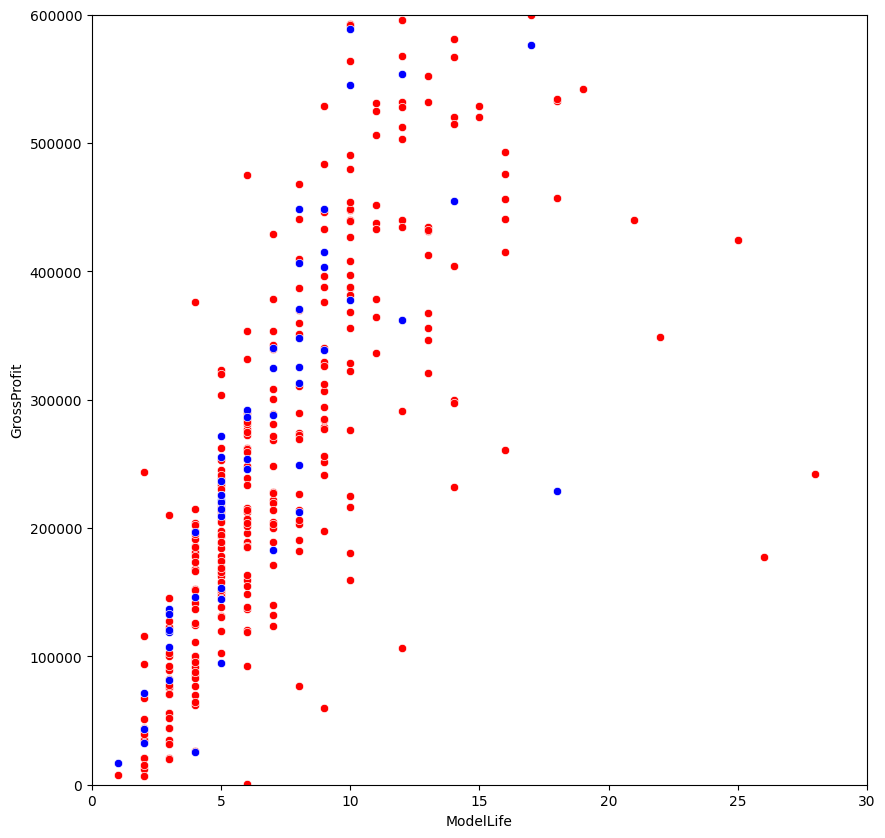

In [18]:
sns.set_palette("pastel")

plt.figure(figsize=(10, 10))
sns.scatterplot(x=df_train['ModelLife'], y=df_train['GrossProfit'], color='red')
sns.scatterplot(x=df_test['ModelLife'], y=df_test['GrossProfit'], color='blue')
plt.xlim([0, 30])
plt.ylim([0, 600000])

plt.xlabel('ModelLife')
plt.ylabel('GrossProfit')

# 予測が大きく外れたレコードの分析

In [19]:
cols = df.columns.tolist()

targets = [
     'Performance',
     'Spec',
     'Content',
     'News',
     'Concept',
     'Period',
     'SaleUnit_eval',
     'Running',
     'Returns',
     'Price_eval']

features = [col for col in cols if col not in targets + ['Name', 'ModelLife', 'ModelLife_category', 'GrossProfit', 'GrossProfit_category', 'KatashikiId', 'Regist_Date', 'Color', 'TypeName', 'TypeName_detail', 'brand_name']]


In [21]:
len(features)

164

In [20]:
from src.modeling import modeling
from src.evaluation import evaluation

# 出力のフォルダ場所
folder = 'output_train/output_20240829'

###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [30]:
def categorize_modellife(x):
    if x >= 0 and x <= 6:
        return 1
    elif x >= 7 and x <= 9:
        return 2
    elif x >= 10 and x <= 13:
        return 3
    elif x >= 14 and x <= 17:
        return 4
    else:
        return 5

def categorize_grossprofit(x):
    if x <= 200000:
        return 1
    elif x > 200000 and x <= 300000:
        return 2
    elif x > 300000 and x <= 400000:
        return 3
    elif x > 400000 and x <= 600000:
        return 4
    elif x > 600000 and x <= 800000:
        return 5
    else:
        return 6


for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))

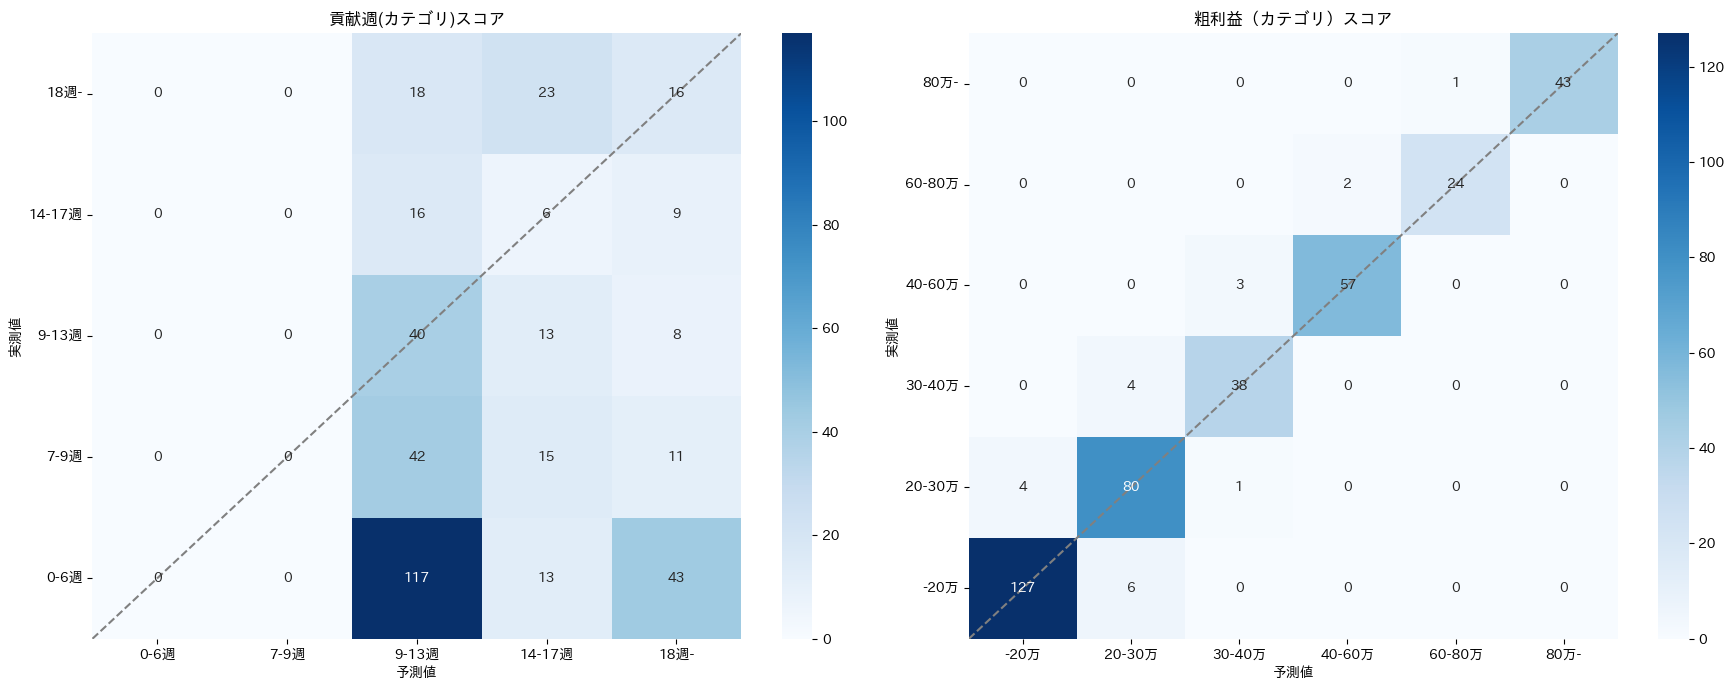

In [31]:
from src.evaluation import evaluation
eval = evaluation(None, None)
tick_labels = [['0-6週', '7-9週', '9-13週', '14-17週', '18週-'],
   ['-20万', '20-30万', '30-40万', '40-60万','60-80万', '80万-']]
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

In [25]:
df_output_train = pd.concat([df_train[['KatashikiId', 'Regist_Date']], df_output_profit_gbm_train], axis=1)
df_output_train['ModelLife_pred_actual_diff'] = df_output_train['ModelLife_pred'] - df_output_train['ModelLife']
df_output_train['GrossProfit_pred_actual_diff'] = df_output_train['GrossProfit_pred'] - df_output_train['GrossProfit']

In [26]:
df_output_train

,KatashikiId,Regist_Date,Kind,ModelLife,GrossProfit,ModelLife_pred,GrossProfit_pred,ModelLife_pred_actual_diff,GrossProfit_pred_actual_diff
0,P2020121508554101,2020-12-22 13:16:29,0,12.0,532293.0,12.367705,528185.286246,0.367705,-4107.713754
1,S2021080911464501,2021-08-09 12:00:30,1,6.0,148296.0,13.620516,156691.261898,7.620516,8395.261898
2,S2021020212072301,2021-02-17 10:00:34,1,16.0,456679.0,13.127609,456726.089493,-2.872391,47.089493
4,P2021040518060201,2021-04-13 14:25:12,0,5.0,194114.0,10.756964,203564.764917,5.756964,9450.764917
6,P2022070514215201,2022-07-14 10:33:29,0,14.0,231903.0,10.870203,225807.527264,-3.129797,-6095.472736
...,...,...,...,...,...,...,...,...,...
521,S2021062315403401,2021-06-25 16:26:40,1,16.0,414858.0,11.856430,424407.742393,-4.143570,9549.742393
522,P2022033112193401,2022-04-04 15:45:18,0,6.0,259259.0,10.815680,258008.913464,4.815680,-1250.086536
523,S2020111815092001,2020-11-24 10:31:18,1,4.0,173230.0,10.525109,189002.335432,6.525109,15772.335432
524,P2022053008143501,2022-06-02 15:29:27,0,8.0,269690.0,12.289552,258691.570475,4.289552,-10998.429525


In [27]:
df_output_train.sort_values(by='ModelLife_pred_actual_diff', ascending=False)

,KatashikiId,Regist_Date,Kind,ModelLife,GrossProfit,ModelLife_pred,GrossProfit_pred,ModelLife_pred_actual_diff,GrossProfit_pred_actual_diff
417,P2021091713003501,2021-09-28 09:18:17,0,3.0,44297.0,15.807047,9.631455e+04,12.807047,52017.545098
36,S2021100514513101,2021-10-14 13:27:53,1,3.0,75716.0,15.028746,1.237181e+05,12.028746,48002.092973
162,S2020020417471501,2020-02-07 13:22:03,1,2.0,20748.0,14.016150,3.127657e+04,12.016150,10528.570931
17,S2023073019490901,2023-08-03 14:00:24,1,2.0,94208.0,13.872600,1.131480e+05,11.872600,18939.957963
218,S2021011816235801,2021-01-25 14:03:53,1,4.0,64547.0,15.200905,6.770885e+04,11.200905,3161.848235
...,...,...,...,...,...,...,...,...,...
511,S2020101418212701,2020-10-29 18:46:32,1,85.0,1147541.0,15.954633,1.139307e+06,-69.045367,-8234.449634
398,P2021060814524701,2021-06-08 22:11:58,0,101.0,3393796.0,17.523321,3.388059e+06,-83.476679,-5737.425481
415,P2020111814152301,2020-11-20 15:50:01,0,130.0,1837553.0,17.542244,1.819433e+06,-112.457756,-18119.867228
40,P2021100515071401,2021-10-12 18:18:16,0,137.0,9325263.0,17.302463,9.312174e+06,-119.697537,-13088.843440


In [28]:
df_output_train.to_csv(folder + '/analysis_train.csv', index=False)

# ここでデフォルトモデルを学習させて比較

In [44]:
#from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

df_output2_test = df_test[['ModelLife', 'GrossProfit', 'ModelLife_category', 'GrossProfit_category']].copy()
df_output2_train = df_train[['ModelLife', 'GrossProfit', 'ModelLife_category', 'GrossProfit_category']].copy()

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    
    #model = RandomForestRegressor(random_state=42)
    model = LGBMRegressor(objective='poisson', random_state=42, verbose=-1)
    model.fit(df_train[features], df_train[target])
    y_pred = model.predict(df_test[features])
    y_pred_train = model.predict(df_train[features])

    df_output2_test[target+'_pred'] = y_pred
    df_output2_train[target+'_pred'] = y_pred_train
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output2_test[target+'_category' + '_pred'] = df_output2_test[target+'_pred'].apply(lambda x : func(x))
    df_output2_train[target+'_category' + '_pred'] = df_output2_train[target+'_pred'].apply(lambda x : func(x))

    rmse = mean_squared_error(df_output2_test[target], df_output2_test[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output2_test[target + '_category'], df_output2_test[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output2_train[target], df_output2_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output2_train[target + '_category'], df_output2_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)

---------------
-Train-
ModelLife
RMSE: 3.554875860659423
正解率: 0.5025641025641026
-Test-
ModelLife
RMSE: 7.444284201544468
正解率: 0.14035087719298245
---------------
-Train-
GrossProfit
RMSE: 114374.91579914564
正解率: 0.5871794871794872
-Test-
GrossProfit
RMSE: 274591.450777374
正解率: 0.2982456140350877


In [45]:
model.__dict__

{'boosting_type': 'gbdt',
 'objective': 'poisson',
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': 42,
 'n_jobs': None,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x218f0327b50>,
 '_evals_result': {},
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': 0,
 '_other_params': {'verbose': -1},
 '_objective': 'poisson',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': None,
 '_n_features': 164,
 '_n_features_in': 164,
 '_classes': None,
 '_n_classes': -1,
 'verbose': -1,
 'fitted_': True}

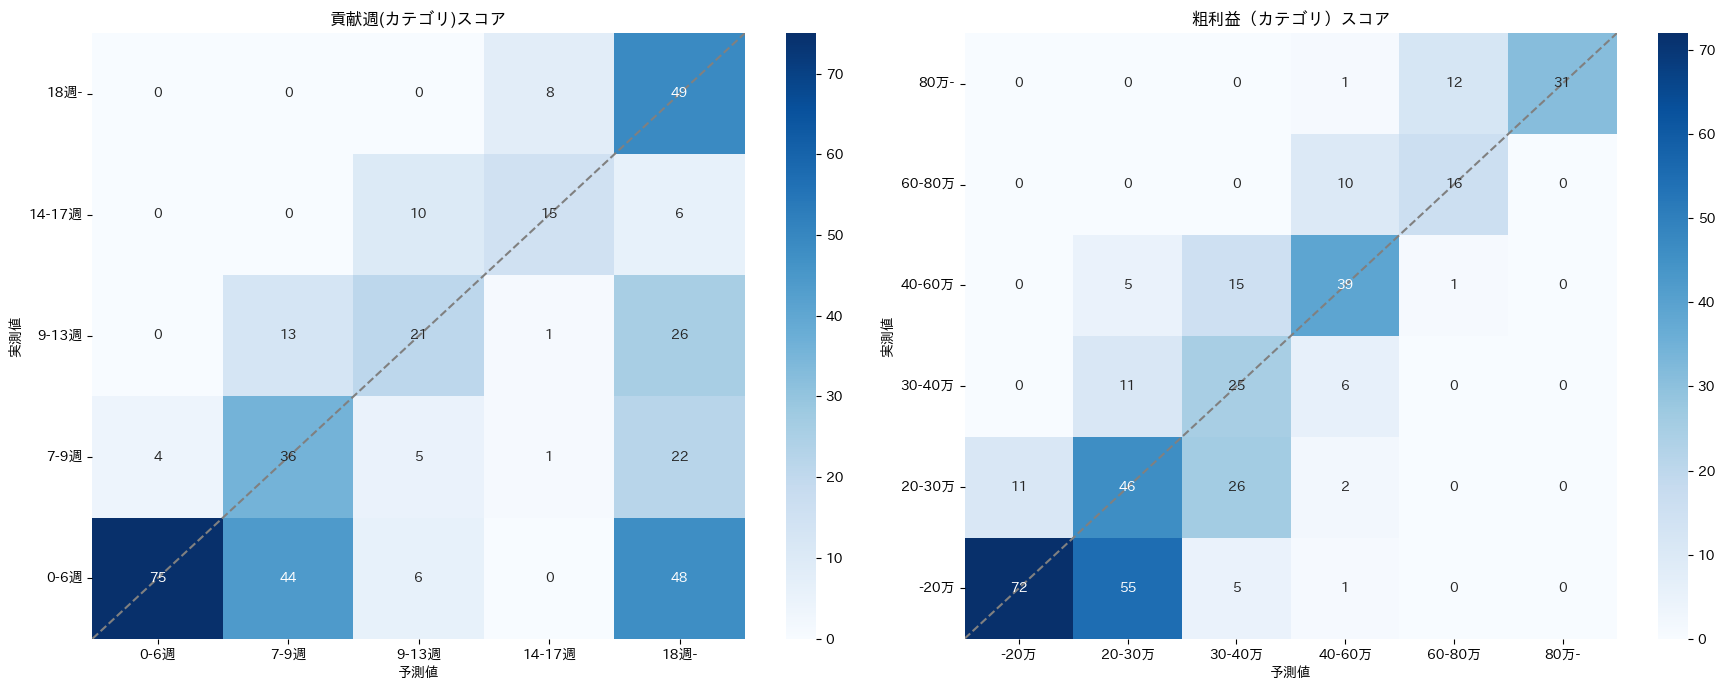

In [46]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output2_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

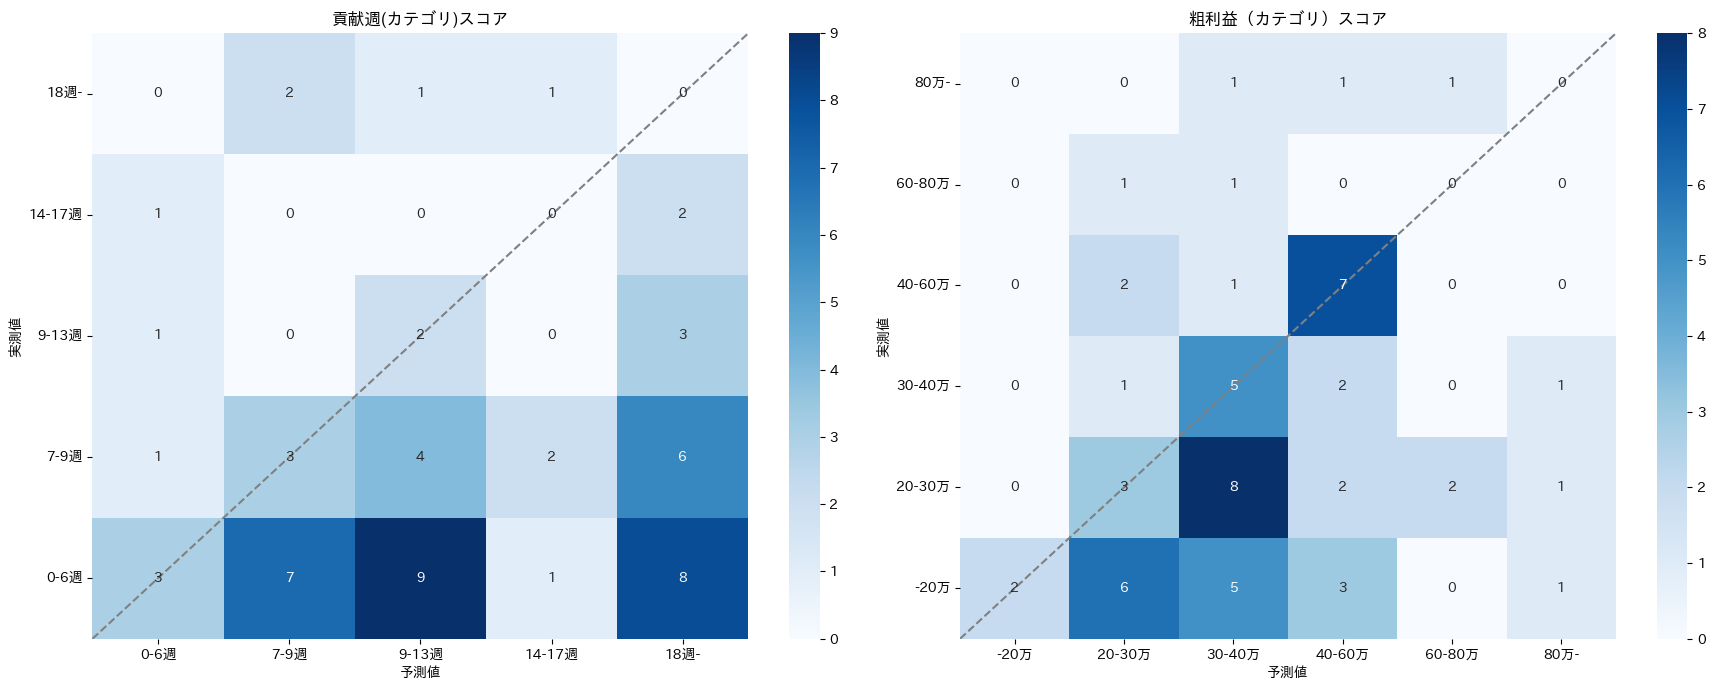

In [47]:
# テストデータ
fig_heatmap = eval.make_multiple_heatmaps(df_output2_test.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

# チューニングされているパラメータを読み込んでここで学習させる

In [36]:
import json
f = open('hyperparameters/best_parameters_profit_lightgbm_poisson.json')
all_params = json.load(f)

In [37]:
all_params

{'ModelLife': {'best_trial_num': 363,
  'best_rmse': 10.656751381545961,
  'best_params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6000559527457271,
   'importance_type': 'split',
   'learning_rate': 0.010010512719802099,
   'max_depth': 7,
   'min_child_samples': 45,
   'min_child_weight': 0.0342120931341024,
   'min_split_gain': 0.0,
   'n_estimators': 126,
   'n_jobs': None,
   'num_leaves': 49,
   'objective': 'poisson',
   'random_state': 42,
   'reg_alpha': 0.9131725527970257,
   'reg_lambda': 1.5209628978180223,
   'subsample': 0.6447528298655301,
   'subsample_for_bin': 200000,
   'subsample_freq': 0,
   'max_bin': 182,
   'lambda_l1': 1.1612229387964144,
   'lambda_l2': 1.6809208502296524,
   'verbose': -1,
   'metric': 'poisson'}},
 'GrossProfit': {'best_trial_num': 647,
  'best_rmse': 341284.50916949066,
  'best_params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.5461965306698913,
   'importance_type': 'spli

In [43]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

df_output3_test = df_test[['ModelLife', 'GrossProfit', 'ModelLife_category', 'GrossProfit_category']].copy()
df_output3_train = df_train[['ModelLife', 'GrossProfit', 'ModelLife_category', 'GrossProfit_category']].copy()

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    
    #model = RandomForestRegressor(random_state=42)
    model = LGBMRegressor(**all_params[target]['best_params'])
    model.fit(df_train[features], df_train[target])
    y_pred = model.predict(df_test[features])
    y_pred_train = model.predict(df_train[features])

    df_output3_test[target+'_pred'] = y_pred
    df_output3_train[target+'_pred'] = y_pred_train
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output3_test[target+'_category' + '_pred'] = df_output3_test[target+'_pred'].apply(lambda x : func(x))
    df_output3_train[target+'_category' + '_pred'] = df_output3_train[target+'_pred'].apply(lambda x : func(x))

    rmse = mean_squared_error(df_output3_test[target], df_output3_test[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output3_test[target + '_category'], df_output3_test[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output3_train[target], df_output3_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output3_train[target + '_category'], df_output3_train[target+'_category' + '_pred'])

    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)

---------------
-Train-
ModelLife
RMSE: 16.77824252976598
正解率: 0.15897435897435896
-Test-
ModelLife
RMSE: 6.983995406333916
正解率: 0.10526315789473684
---------------
-Train-
GrossProfit
RMSE: 14462.566545914793
正解率: 0.9461538461538461
-Test-
GrossProfit
RMSE: 266901.6446309191
正解率: 0.38596491228070173


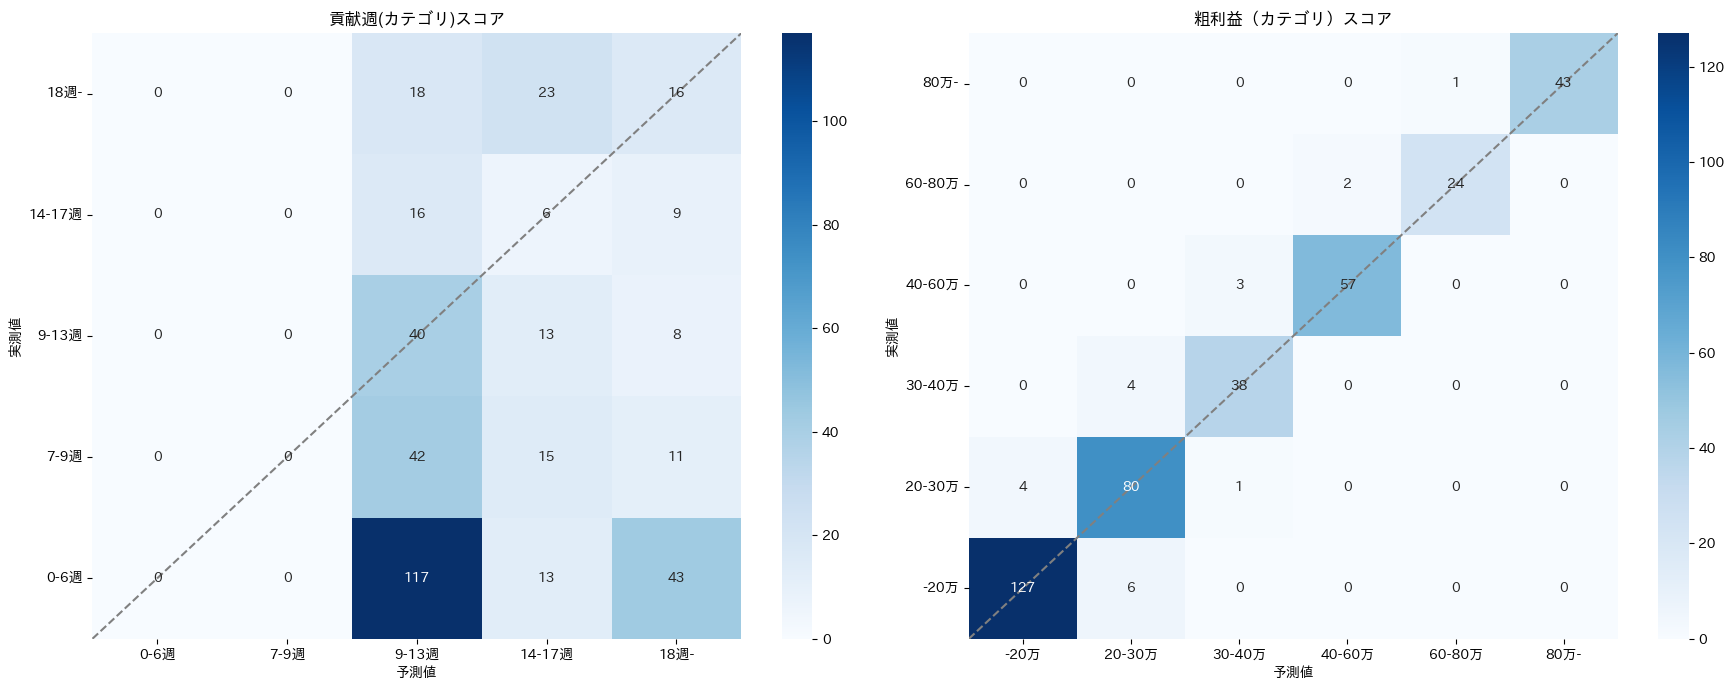

In [41]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output3_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

# ハイパーパラメータチューニングを再度試みる（チューニングの際の評価指標をポアソンにした）

In [48]:
from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing.json')

mt_gbm.tune_models(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000,
                   loss='poisson') 

最適化: minimize  poisson
--- ModelLife ---
trial: 606
poisson : -12.630161700731595
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 33, 'max_depth': 15, 'learning_rate': 0.011734088970406566, 'n_estimators': 123, 'min_child_samples': 47, 'min_child_weight': 0.042593659896378, 'subsample': 0.5662713729587884, 'colsample_bytree': 0.60753762308948, 'reg_alpha': 0.12666738785237977, 'reg_lambda': 1.6492177434200035, 'max_bin': 228, 'lambda_l1': 0.06100219343176455, 'lambda_l2': 0.8371005937227944}
--- GrossProfit ---
trial: 597
poisson : -4542622.211385313
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 38, 'max_depth': 9, 'learning_rate': 0.011004713840208983, 'n_estimators': 100, 'min_child_samples': 26, 'min_child_weight': 0.04029820751703301, 'subsample': 0.7484356403021476, 'colsample_bytree': 0.5224241088478209, 'reg_alpha': 0.5063957852897257, 'reg_lambda': 1.5817466467430314, 'max_bin': 115, 'lambda_l1': 1.229425096348173, 'lambda_l2': 0.10053575366662264}


In [49]:
from src.modeling import modeling
from src.evaluation import evaluation
###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [50]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))
    
    rmse = mean_squared_error(df_output_profit_gbm[target], df_output_profit_gbm[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output_profit_gbm[target + '_category'], df_output_profit_gbm[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output_profit_gbm_train[target], df_output_profit_gbm_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output_profit_gbm_train[target + '_category'], df_output_profit_gbm_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    print(df_output_profit_gbm_train[target+ '_category'+'_pred'].value_counts())
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output_profit_gbm[target+ '_category'+'_pred'].value_counts())

---------------
-Train-
ModelLife
RMSE: 16.675952642789284
正解率: 0.16153846153846155
ModelLife_category_pred
3    209
5    104
4     76
2      1
Name: count, dtype: int64
-Test-
ModelLife
RMSE: 7.011576191193742
正解率: 0.10526315789473684
ModelLife_category_pred
3    39
5    10
4     8
Name: count, dtype: int64
---------------
-Train-
GrossProfit
RMSE: 589168.0485080999
正解率: 0.16923076923076924
GrossProfit_category_pred
4    224
3    157
5      8
6      1
Name: count, dtype: int64
-Test-
GrossProfit
RMSE: 262692.3977903188
正解率: 0.15789473684210525
GrossProfit_category_pred
4    43
3    14
Name: count, dtype: int64


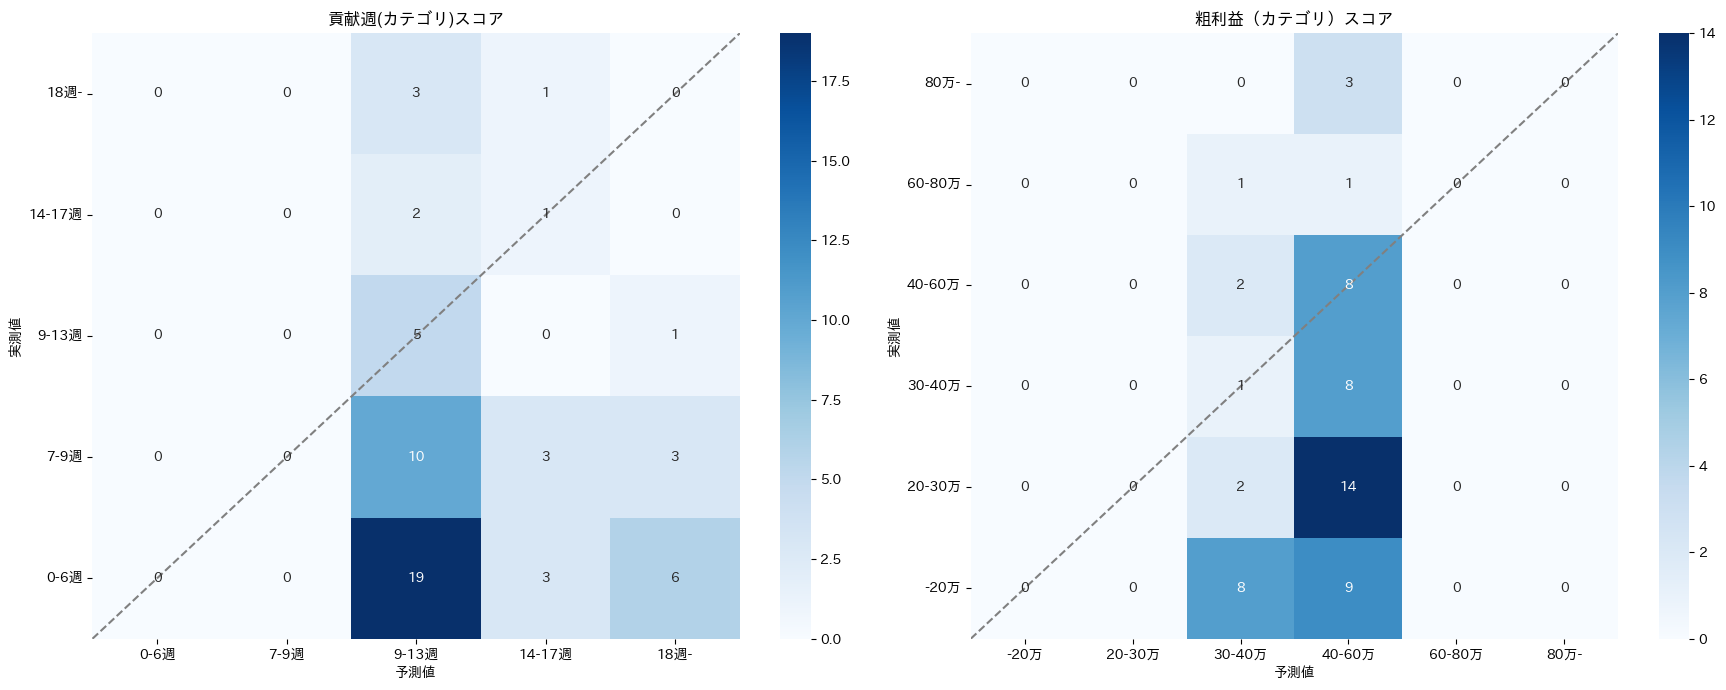

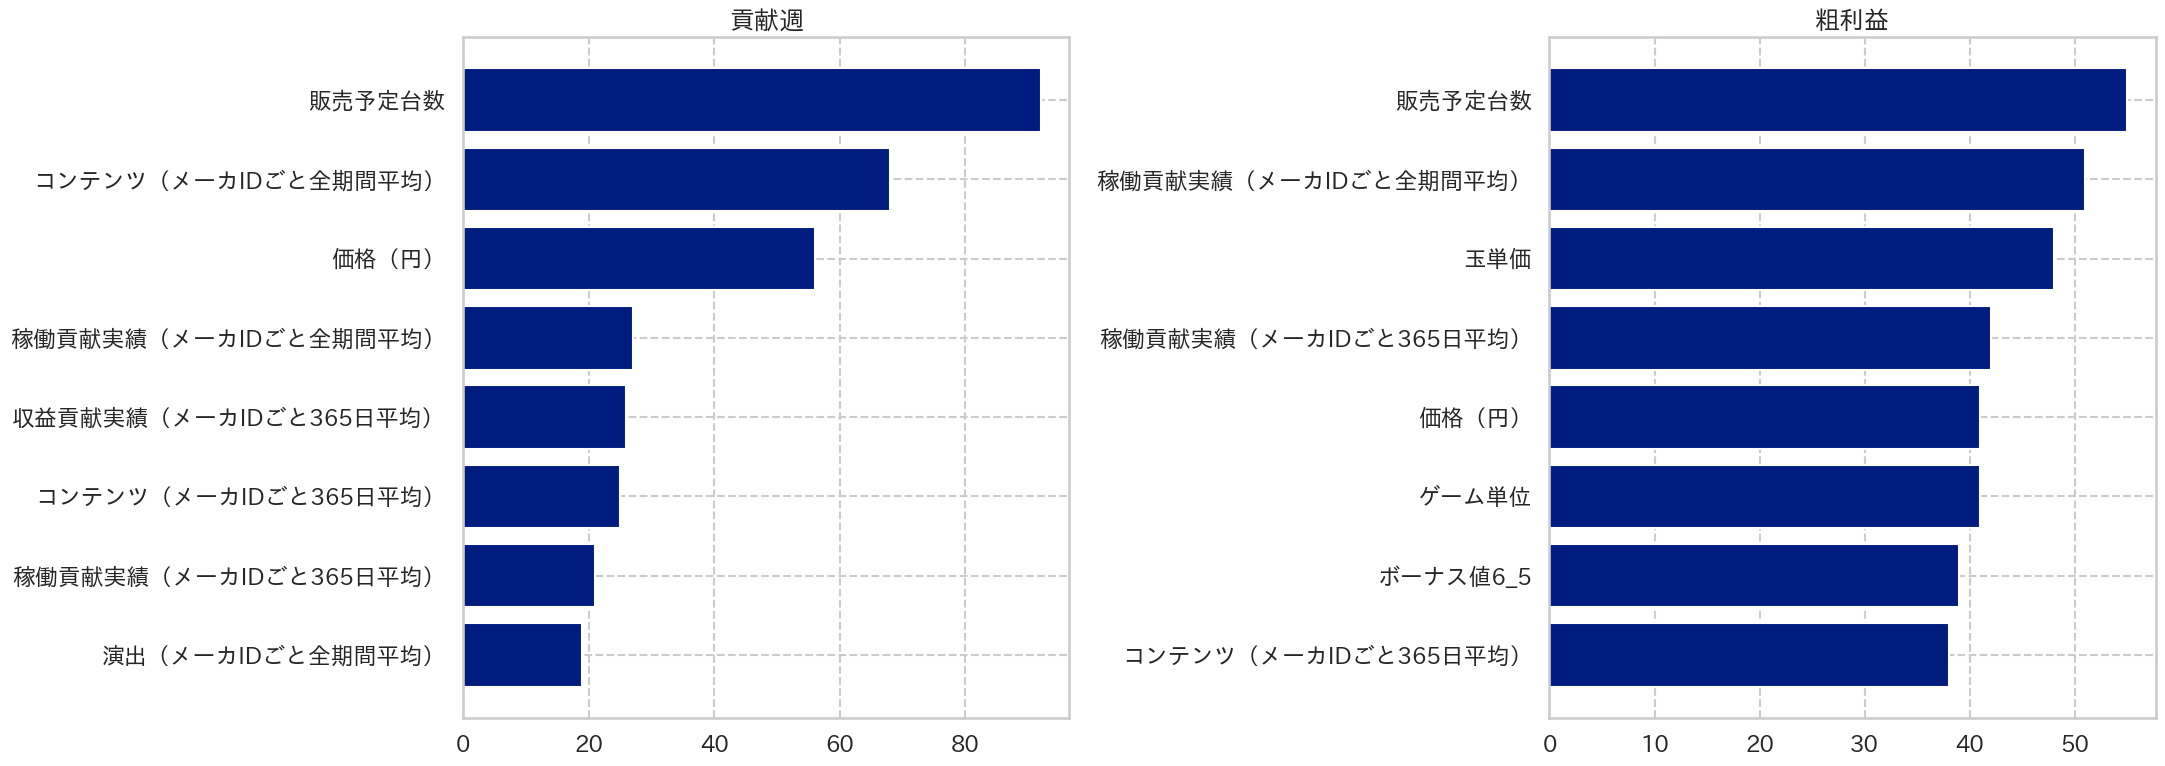

In [51]:
import importlib
import sys
importlib.reload(sys.modules[evaluation.__module__])

from src.evaluation import evaluation

eval = evaluation(None, None)

tick_labels = [['0-6週', '7-9週', '9-13週', '14-17週', '18週-'],
   ['-20万', '20-30万', '30-40万', '40-60万','60-80万', '80万-']]

fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)
fig_importance = eval.plot_feature_importance(models_profit_gbm, ['ModelLife', 'GrossProfit'],
                    features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))

In [52]:
# あれ？？？。。。

# 外れ値の処理を行って学習

In [62]:
import numpy as np
from scipy.stats import zscore

#def remove_numeric_outliers_zscore(df, columns, threshold=3):
#    df_numeric = df[columns] 
#    
#    z_scores = np.abs(zscore(df_numeric))
#    outlier_indices = np.where(z_scores > threshold)    
#    df_cleaned = df.drop(df.index[outlier_indices[0]])
#    return df_cleaned

def remove_numeric_outliers_zscore(df, threshold=3):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_columns] 
    
    from scipy.stats import zscore
    z_scores = np.abs(zscore(df_numeric))
    outlier_indices = np.where(z_scores > threshold)    
    df_cleaned = df.drop(df.index[outlier_indices[0]])
    return df_cleaned

In [63]:
print(len(df))
df_cleaned = remove_numeric_outliers_zscore(df.copy(), threshold=4)
print(len(df_cleaned))

447
418


In [64]:
# 学習とテストデータの定義
df_train_cleaned = df[df['Regist_Date'] < df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]
df_test_cleaned = df[df['Regist_Date'] >= df['Regist_Date'].min() + pd.DateOffset(days=365*4 - 90)]

In [66]:
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_2.json')

mt_gbm.tune_models(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train_cleaned,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000,
                   loss='rmse') # ここをrmseにもどす 

最適化: minimize  rmse
--- ModelLife ---
trial: 363
rmse : 10.656751381545961
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 7, 'learning_rate': 0.010010512719802099, 'n_estimators': 126, 'min_child_samples': 45, 'min_child_weight': 0.0342120931341024, 'subsample': 0.6447528298655301, 'colsample_bytree': 0.6000559527457271, 'reg_alpha': 0.9131725527970257, 'reg_lambda': 1.5209628978180223, 'max_bin': 182, 'lambda_l1': 1.1612229387964144, 'lambda_l2': 1.6809208502296524}
--- GrossProfit ---
trial: 647
rmse : 341284.50916949066
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 27, 'max_depth': 13, 'learning_rate': 0.21911313490399548, 'n_estimators': 355, 'min_child_samples': 24, 'min_child_weight': 0.021439918670541805, 'subsample': 0.5883949679848673, 'colsample_bytree': 0.5461965306698913, 'reg_alpha': 0.42410696917998164, 'reg_lambda': 0.6631813799429345, 'max_bin': 208, 'lambda_l1': 0.16822570725967065, 'lambda_l2': 1.1913945469350675}


In [71]:
from src.modeling import modeling
from src.evaluation import evaluation
###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_2.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test_cleaned)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train_cleaned)

In [72]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))
    
    rmse = mean_squared_error(df_output_profit_gbm[target], df_output_profit_gbm[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output_profit_gbm[target + '_category'], df_output_profit_gbm[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output_profit_gbm_train[target], df_output_profit_gbm_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output_profit_gbm_train[target + '_category'], df_output_profit_gbm_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    print(df_output_profit_gbm_train[target+ '_category'+'_pred'].value_counts())
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output_profit_gbm[target+ '_category'+'_pred'].value_counts())

---------------
-Train-
ModelLife
RMSE: 16.77824252976598
正解率: 0.15897435897435896
ModelLife_category_pred
3    233
5     87
4     70
Name: count, dtype: int64
-Test-
ModelLife
RMSE: 6.983995406333916
正解率: 0.10526315789473684
ModelLife_category_pred
3    42
5     9
4     6
Name: count, dtype: int64
---------------
-Train-
GrossProfit
RMSE: 14462.566545914793
正解率: 0.9461538461538461
GrossProfit_category_pred
1    131
2     90
4     59
6     43
3     42
5     25
Name: count, dtype: int64
-Test-
GrossProfit
RMSE: 266901.6446309191
正解率: 0.38596491228070173
GrossProfit_category_pred
3    18
2    14
1    11
4    10
6     2
5     2
Name: count, dtype: int64


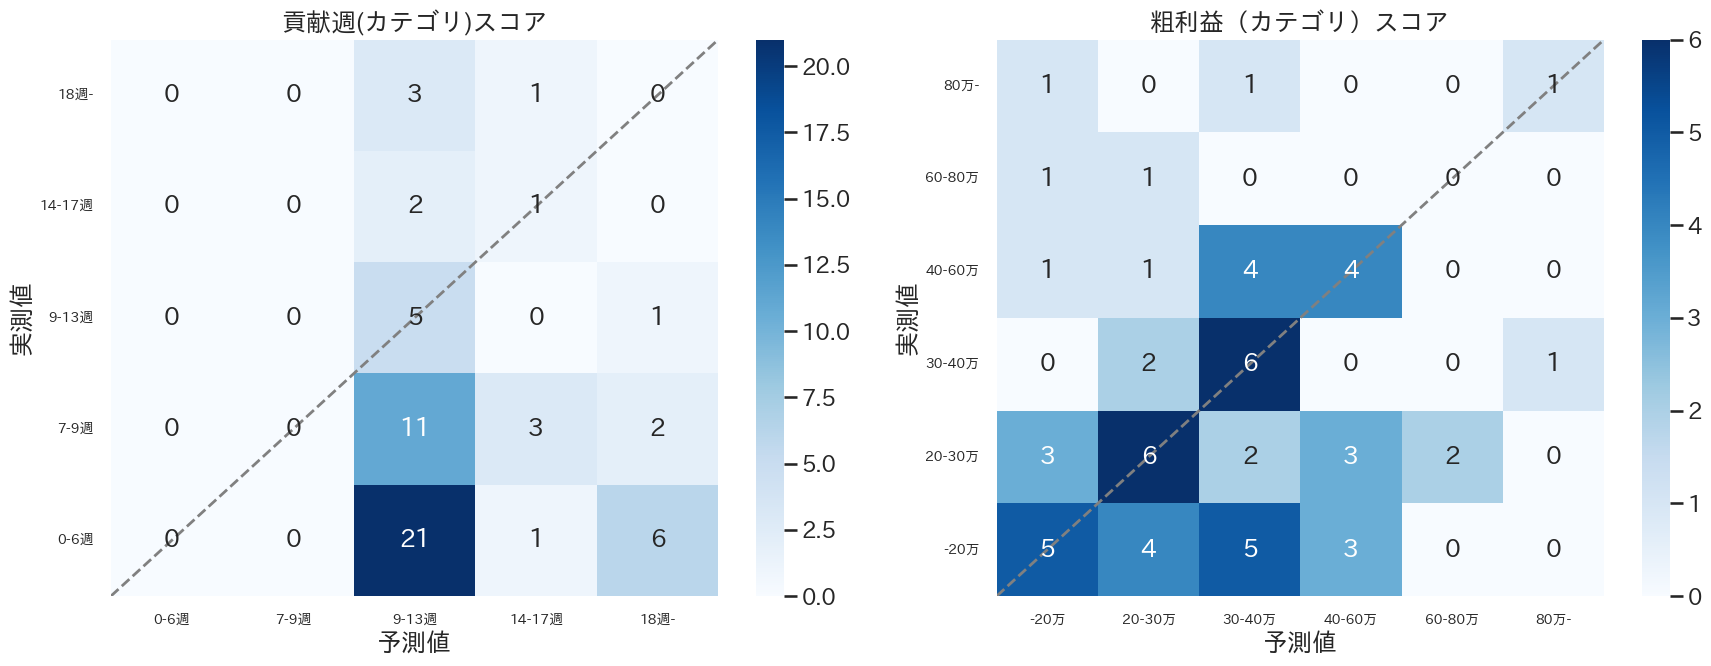

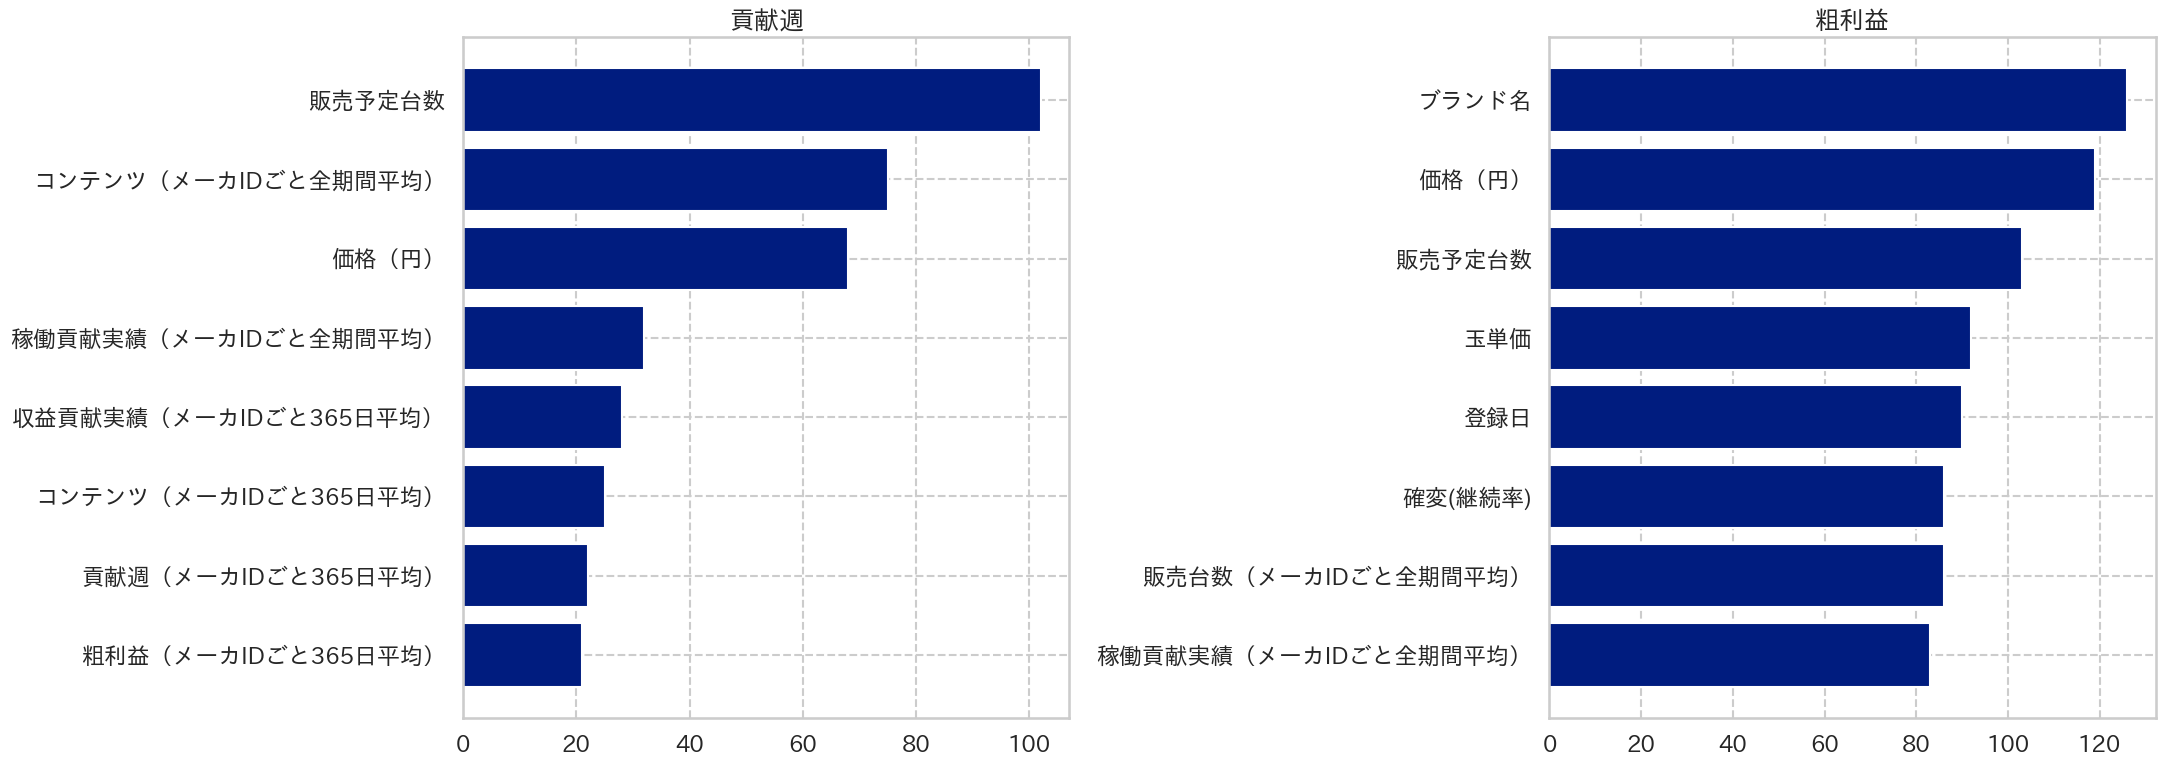

In [73]:
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)
fig_importance = eval.plot_feature_importance(models_profit_gbm, ['ModelLife', 'GrossProfit'],
                    features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))

# 学習率のチューニングは含めずにチューニングから

スクリプトの修正を行った

In [75]:
import importlib
import sys
importlib.reload(sys.modules[model_tuning.__module__])

from src.hyperparameters_tuning import model_tuning

mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_3.json')

mt_gbm.tune_models(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000,
                   loss='rmse') 

最適化: minimize  rmse
--- ModelLife ---
trial: 602
rmse : 10.53172900842756
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 36, 'max_depth': 10, 'n_estimators': 351, 'min_child_samples': 29, 'min_child_weight': 0.04108655676774986, 'subsample': 0.5417534840336812, 'colsample_bytree': 0.6171961678592794, 'reg_alpha': 0.3932747158837922, 'reg_lambda': 1.3599709519195067, 'max_bin': 117, 'lambda_l1': 1.1662239924009454, 'lambda_l2': 1.752415571678454}
--- GrossProfit ---
trial: 910
rmse : 348374.45158374286
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 6, 'n_estimators': 385, 'min_child_samples': 24, 'min_child_weight': 0.0005961261728244449, 'subsample': 0.7535665739716503, 'colsample_bytree': 0.6582699260881071, 'reg_alpha': 1.0028219776337628, 'reg_lambda': 0.25674814277062463, 'max_bin': 233, 'lambda_l1': 0.528182441404166, 'lambda_l2': 0.4313439061220181}


In [77]:
###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_3.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [78]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))
    
    rmse = mean_squared_error(df_output_profit_gbm[target], df_output_profit_gbm[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output_profit_gbm[target + '_category'], df_output_profit_gbm[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output_profit_gbm_train[target], df_output_profit_gbm_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output_profit_gbm_train[target + '_category'], df_output_profit_gbm_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    print(df_output_profit_gbm_train[target+ '_category'+'_pred'].value_counts())
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output_profit_gbm[target+ '_category'+'_pred'].value_counts())

---------------
-Train-
ModelLife
RMSE: 1.420100342027393
正解率: 0.6666666666666666
ModelLife_category_pred
5    149
1    124
2     54
3     42
4     21
Name: count, dtype: int64
-Test-
ModelLife
RMSE: 6.915533246717238
正解率: 0.24561403508771928
ModelLife_category_pred
5    16
2    15
3    12
1    11
4     3
Name: count, dtype: int64
---------------
-Train-
GrossProfit
RMSE: 44884.7031023991
正解率: 0.7743589743589744
GrossProfit_category_pred
1    114
2    111
4     58
3     45
6     39
5     23
Name: count, dtype: int64
-Test-
GrossProfit
RMSE: 265314.30751514534
正解率: 0.3684210526315789
GrossProfit_category_pred
2    22
3    12
4     9
1     8
5     6
Name: count, dtype: int64


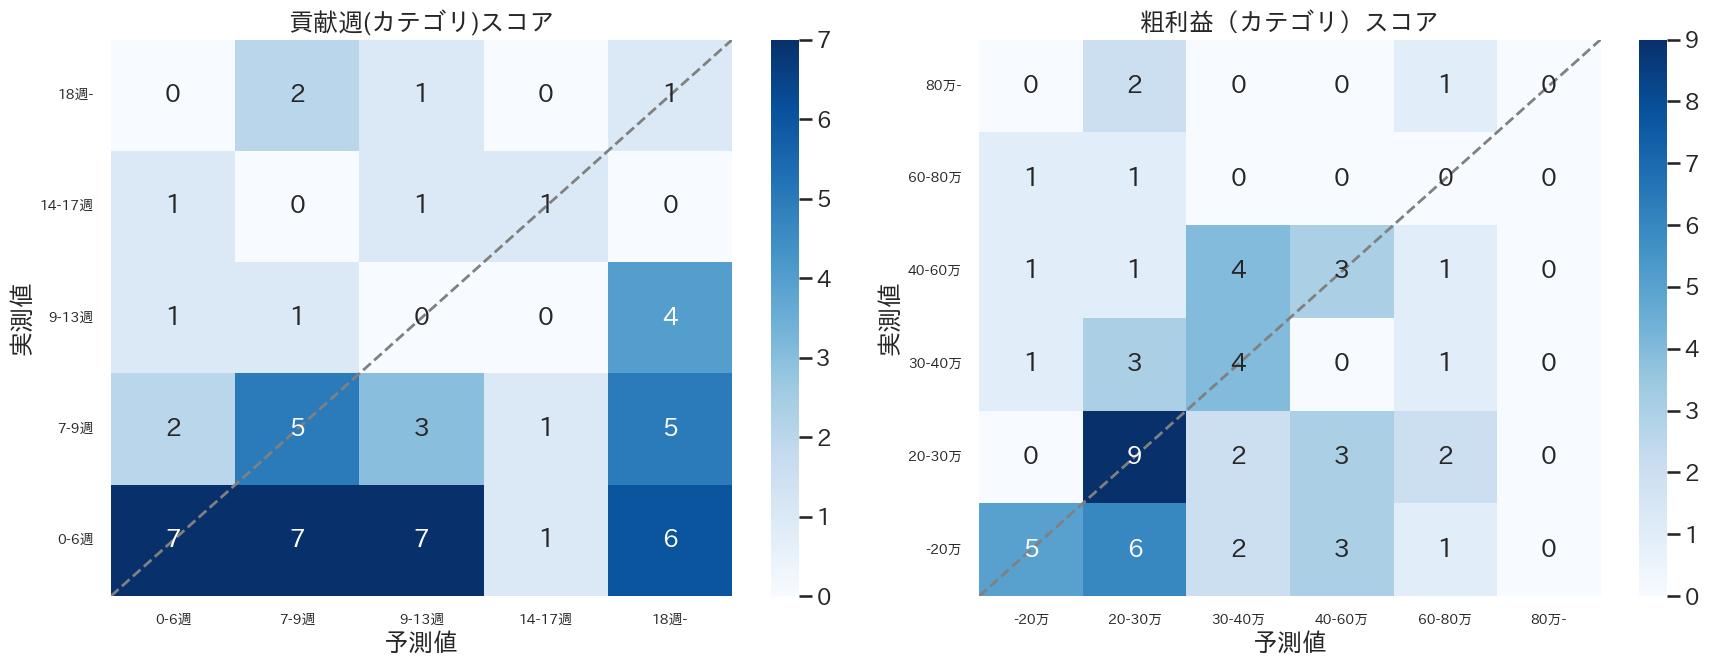

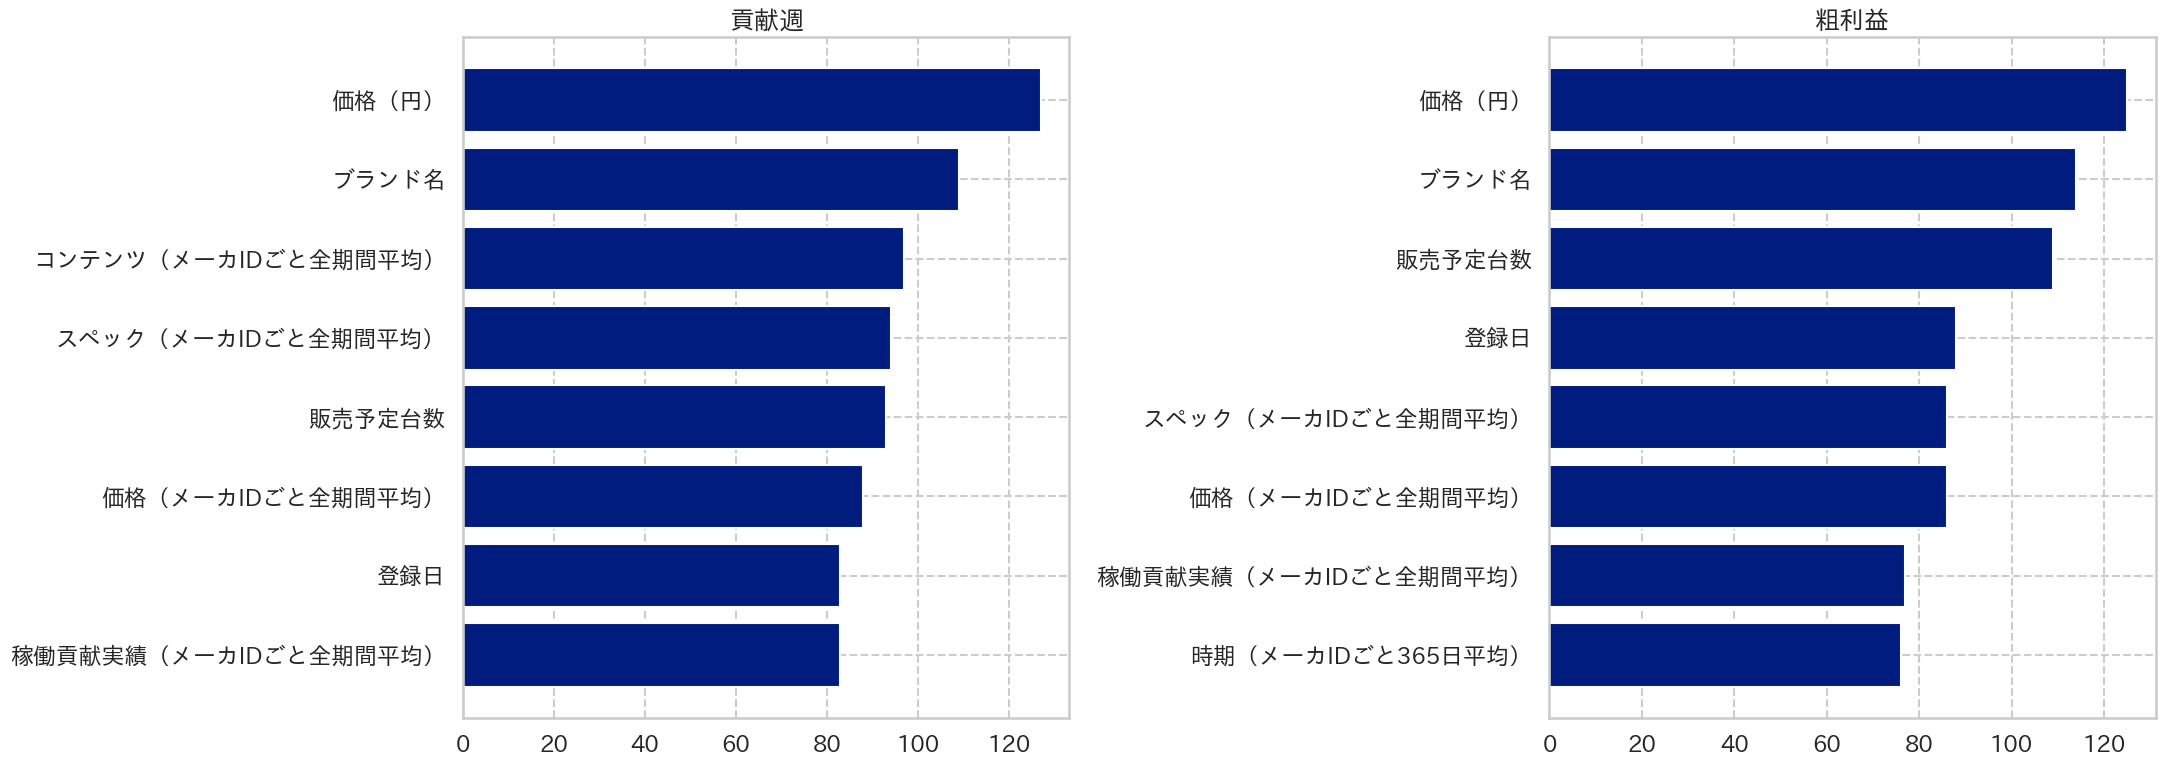

In [79]:
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)
fig_importance = eval.plot_feature_importance(models_profit_gbm, ['ModelLife', 'GrossProfit'],
                    features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))

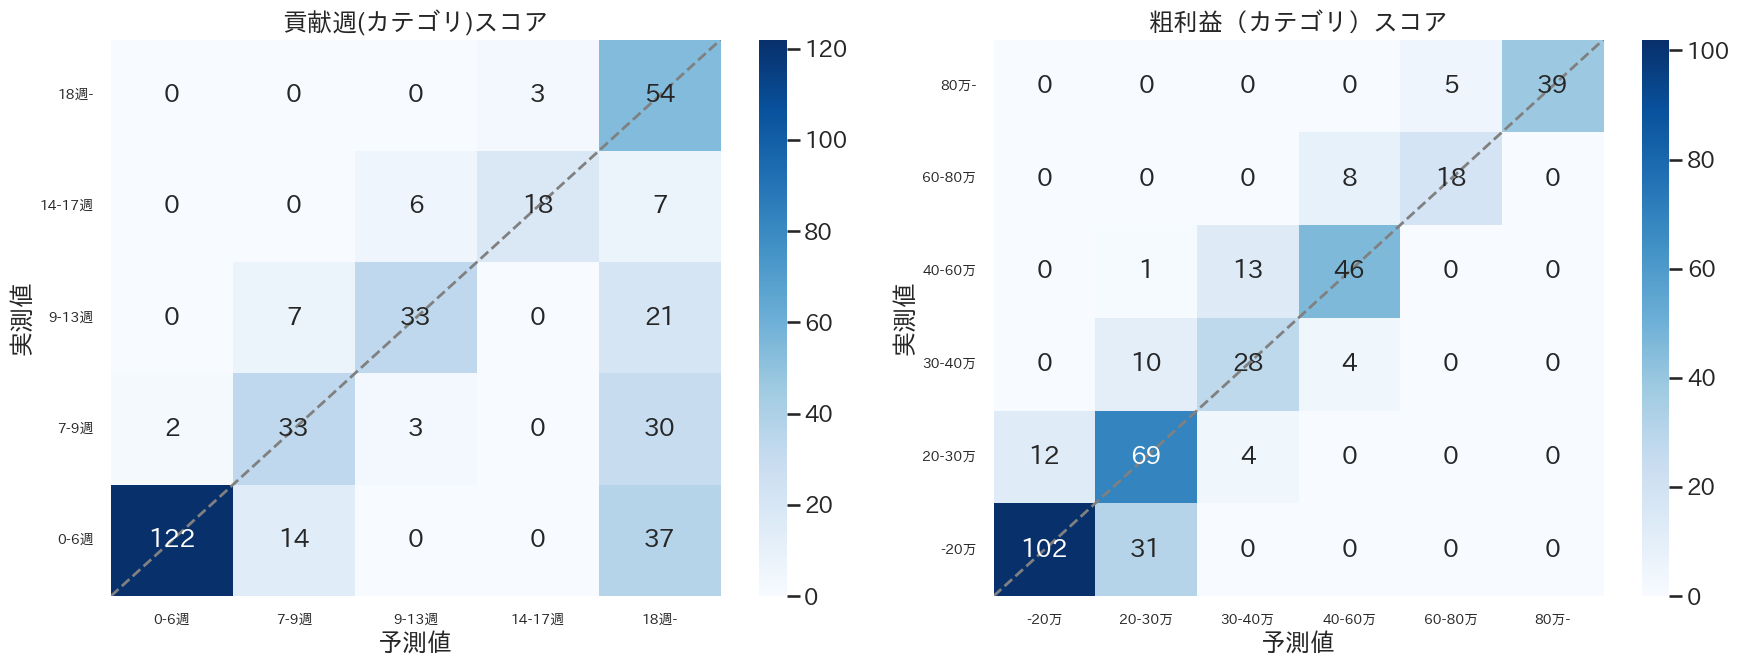

In [80]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)

# num_boost_roundとlearning_rate両方をチューニングに入れる

In [85]:
import importlib
import sys
importlib.reload(sys.modules[model_tuning.__module__])

from src.hyperparameters_tuning import model_tuning
 
mt_gbm = model_tuning(file_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_4.json')

mt_gbm.tune_models(features,
                   ['ModelLife', 'GrossProfit'],
                   df_train,
                   model_kind='lightgbm_regressor_poisson',
                   n_trials=1000,
                   loss='rmse') 

最適化: minimize  rmse
--- ModelLife ---
trial: 261
rmse : 9.829239702547463
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 23, 'max_depth': 13, 'learning_rate': 0.24697662458684294, 'n_estimators': 478, 'min_child_samples': 27, 'min_child_weight': 0.028619940899153193, 'subsample': 0.940672879402535, 'colsample_bytree': 0.7185963104278698, 'reg_alpha': 1.0373981409028814, 'reg_lambda': 1.3864999913173666, 'max_bin': 216, 'lambda_l1': 0.21473413365477856, 'lambda_l2': 1.2785695147577951}
--- GrossProfit ---
trial: 310
rmse : 343168.82233748137
ベストパラメータ: {'boosting_type': 'gbdt', 'num_leaves': 30, 'max_depth': 6, 'learning_rate': 0.21171753912978797, 'n_estimators': 705, 'min_child_samples': 25, 'min_child_weight': 0.020826350628679026, 'subsample': 0.5599676988519694, 'colsample_bytree': 0.9662088497921133, 'reg_alpha': 1.1054379189587784, 'reg_lambda': 1.744042449332458, 'max_bin': 149, 'lambda_l1': 0.7417280050611498, 'lambda_l2': 0.694158952302377}


In [86]:
###############パラメータを読み込んで学習と推論　###############
from src.modeling import modeling
m = modeling(features, targets=['ModelLife', 'GrossProfit'])

# lightgbm
models_profit_gbm = m.load_and_train_all(df_train,
                              param_path='hyperparameters/best_parameters_profit_lightgbm_poisson_testing_4.json',
                              model_kind='lightgbm_regressor')
df_output_profit_gbm = m.predict_all(models_profit_gbm, df_test)
df_output_profit_gbm_train = m.predict_all(models_profit_gbm, df_train)

In [87]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

for target in ['ModelLife', 'GrossProfit']: # 元のデータにフィッテイング
    func = categorize_modellife if target == 'ModelLife' else categorize_grossprofit
    df_output_profit_gbm[target+'_category' + '_pred'] = df_output_profit_gbm[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm[target+'_category'] = df_output_profit_gbm[target].apply(lambda x : func(x))

    df_output_profit_gbm_train[target+'_category' + '_pred'] = df_output_profit_gbm_train[target+'_pred'].apply(lambda x : func(x))
    df_output_profit_gbm_train[target+'_category'] = df_output_profit_gbm_train[target].apply(lambda x : func(x))
    
    rmse = mean_squared_error(df_output_profit_gbm[target], df_output_profit_gbm[target+ '_pred'], squared=False)
    accuracy = accuracy_score(df_output_profit_gbm[target + '_category'], df_output_profit_gbm[target+'_category' + '_pred'])

    rmse_train = mean_squared_error(df_output_profit_gbm_train[target], df_output_profit_gbm_train[target+ '_pred'], squared=False)
    accuracy_train = accuracy_score(df_output_profit_gbm_train[target + '_category'], df_output_profit_gbm_train[target+'_category' + '_pred'])
    
    print('---------------')
    print('-Train-')
    print(target)
    print('RMSE:', rmse_train)
    print('正解率:', accuracy_train)
    print(df_output_profit_gbm_train[target+ '_category'+'_pred'].value_counts())
    
    print('-Test-')    
    print(target)
    print('RMSE:', rmse)
    print('正解率:', accuracy)
    print(df_output_profit_gbm[target+ '_category'+'_pred'].value_counts())

---------------
-Train-
ModelLife
RMSE: 0.22322947502320628
正解率: 0.8307692307692308
ModelLife_category_pred
1    159
5    123
2     46
3     41
4     21
Name: count, dtype: int64
-Test-
ModelLife
RMSE: 7.24872487545962
正解率: 0.22807017543859648
ModelLife_category_pred
1    19
5    16
3    10
2     9
4     3
Name: count, dtype: int64
---------------
-Train-
GrossProfit
RMSE: 7658.246620583009
正解率: 0.9769230769230769
GrossProfit_category_pred
1    132
2     87
4     59
6     44
3     42
5     26
Name: count, dtype: int64
-Test-
GrossProfit
RMSE: 275472.64177672984
正解率: 0.3508771929824561
GrossProfit_category_pred
2    17
1    13
3    12
4    11
5     2
6     2
Name: count, dtype: int64


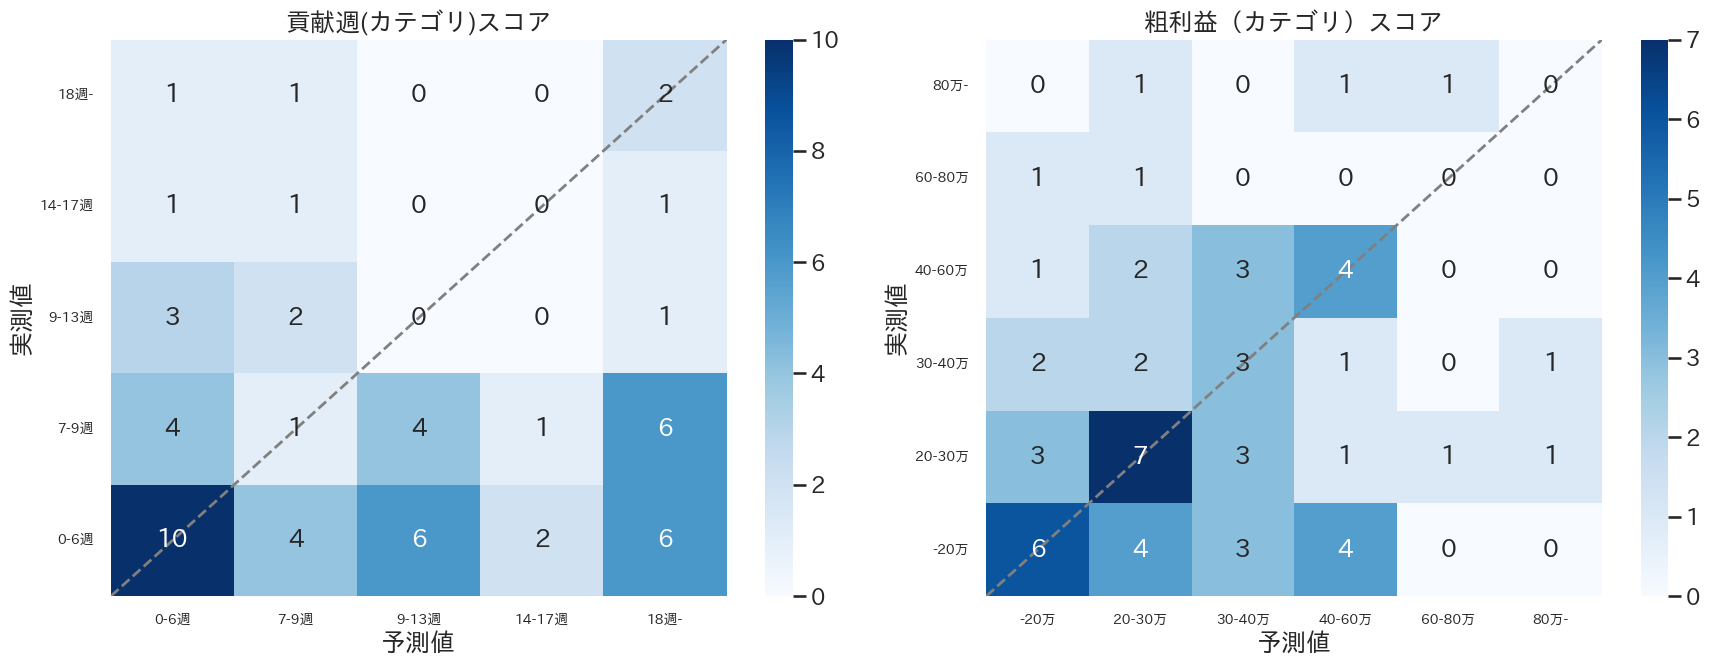

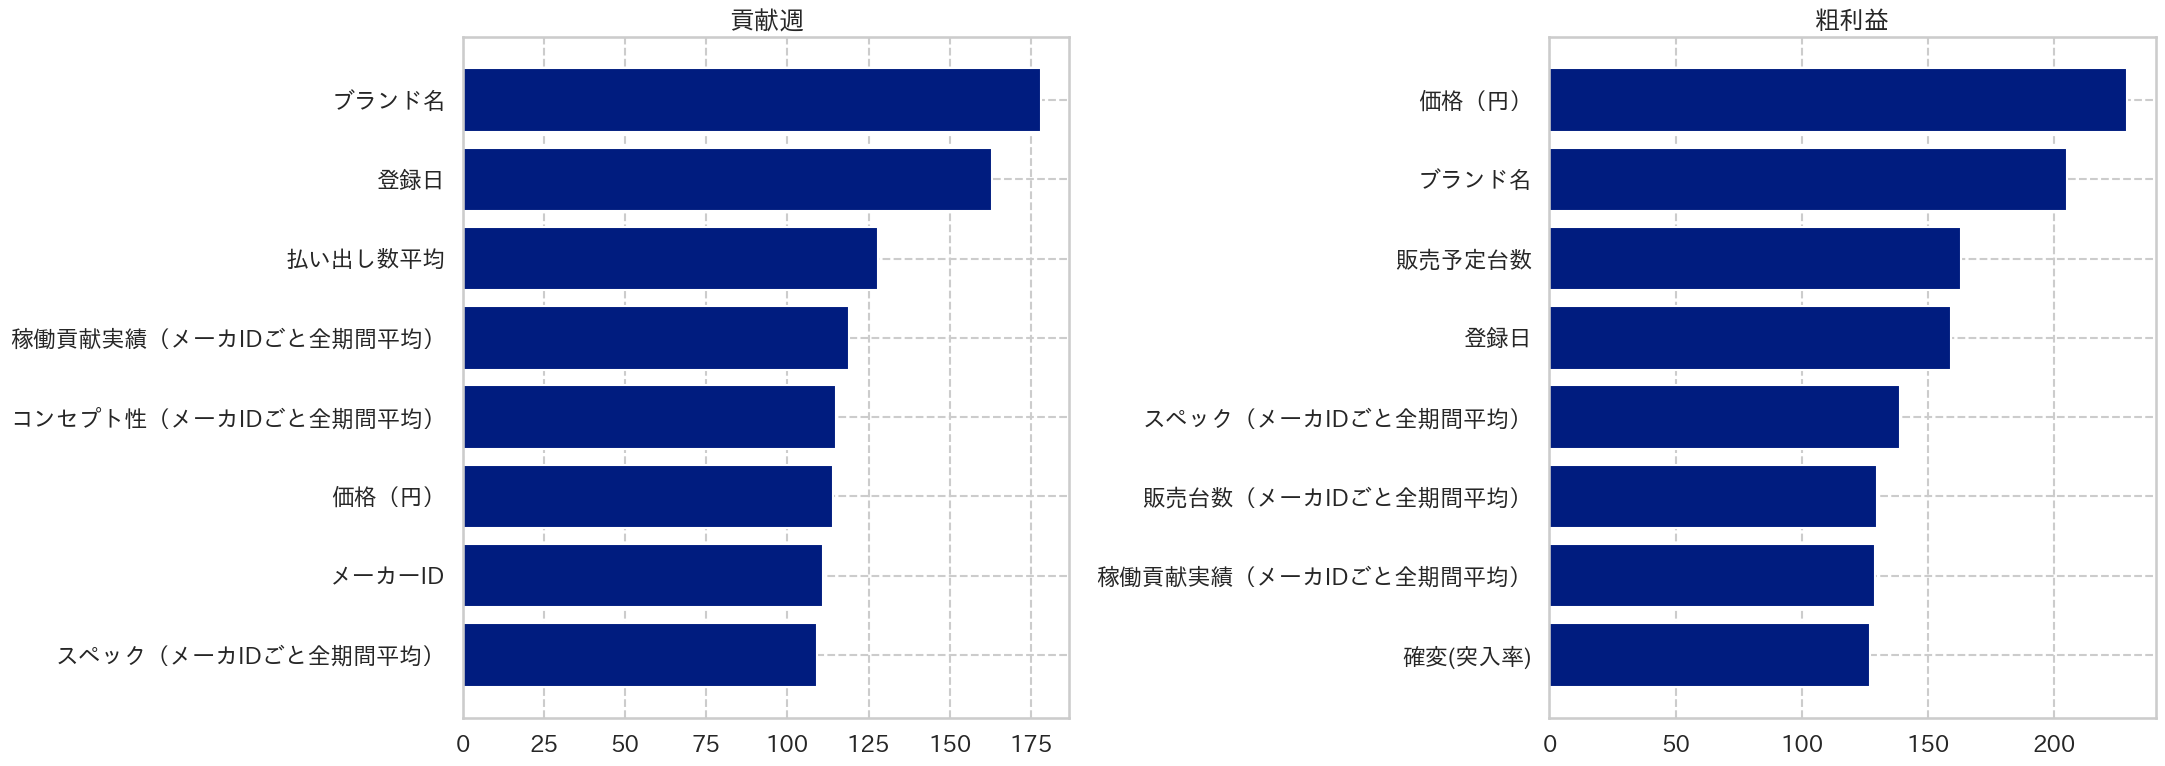

In [88]:
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)
fig_importance = eval.plot_feature_importance(models_profit_gbm, ['ModelLife', 'GrossProfit'],
                    features=features, N=8, fig_N_rows=1, fig_N_cols=2, figsize=(22, 8))

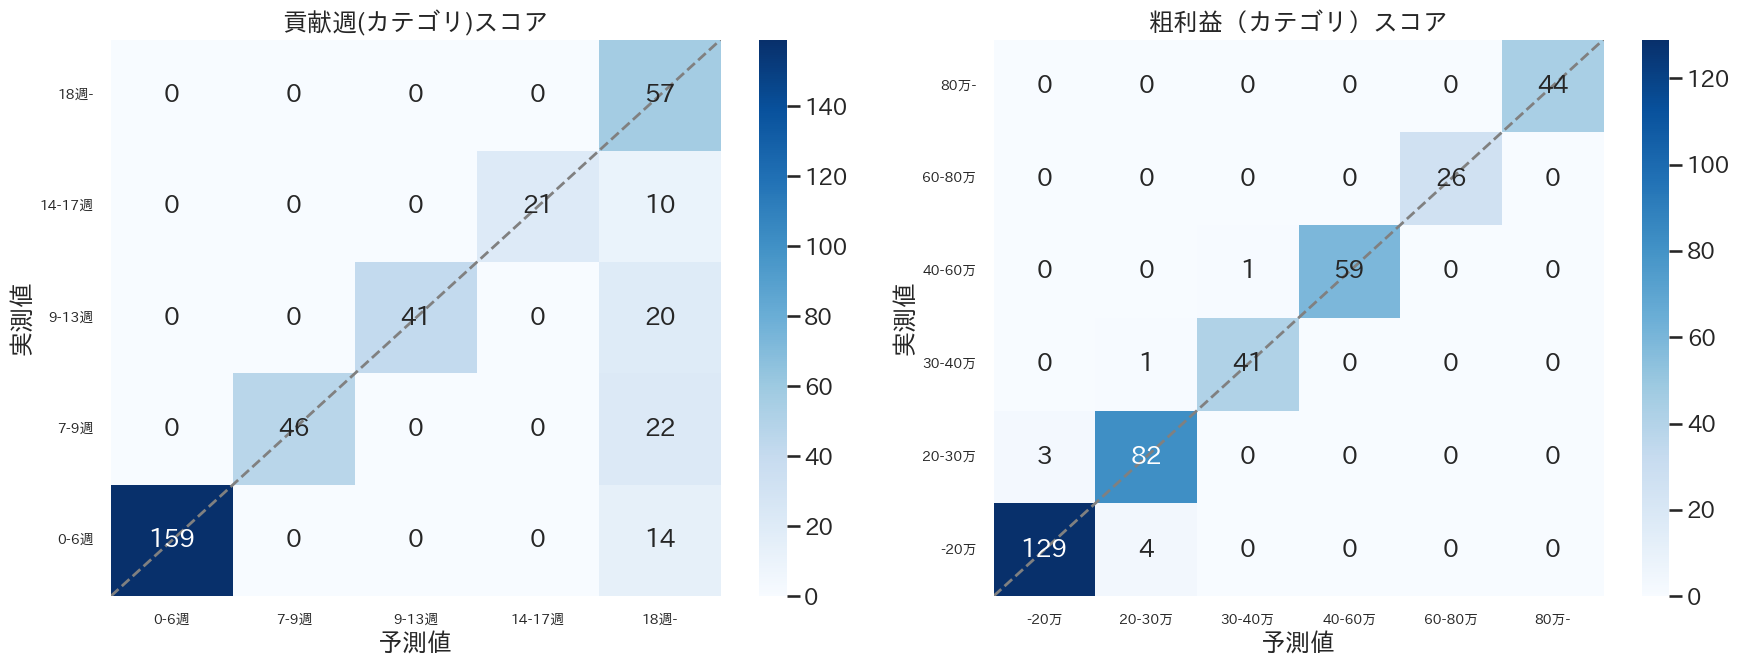

In [89]:
# 学習データ
fig_heatmap = eval.make_multiple_heatmaps(df_output_profit_gbm_train.copy(), [0, 0], [5, 6], N=[6, 7],
                              targets=['ModelLife_category', 'GrossProfit_category'],
                              fig_N_rows=1, fig_N_cols=2, figsize=(18, 7), label_decimals=0, tick_labels=tick_labels)